# Exploratory Modelling
This notebook performs exploratory modeling to analyze base and extreme scenarios, helping to identify potential trade-offs in flood risk management policies.

In [1]:
"""
This script demonstrates the usage of the EMA Workbench for model-based decision-making. The dike model is investigated by setting all the levers to 0 and 1. 
"""

from dike_model_function import DikeNetwork
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench import (
    Model,
    RealParameter, 
    IntegerParameter,
    CategoricalParameter,
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    Scenario
)
from ema_workbench.util import save_results

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from SALib.sample.latin import sample as lhs_sample
from SALib.util import scale_samples
import numpy as np

In [2]:
# Instantiate the model
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 1 is chosen
# As this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(6)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

Explore the behavior of the system in the absence of any release using 1000 scenarios

In [3]:
# Extract bounds for the uncertainties
problem = {
    'num_vars': len(uncertainties),
    'names': [unc.name for unc in uncertainties],
    'bounds': []
}

for unc in uncertainties:
    if isinstance(unc, (RealParameter, IntegerParameter)):
        problem['bounds'].append([unc.lower_bound, unc.upper_bound])
    elif isinstance(unc, CategoricalParameter):
        # Handle categorical parameters separately
        problem['bounds'].append([0, len(unc.categories) - 1])

In [4]:
num_scenarios = 40000

In [5]:
# Define a dictionary with all levers set to zero
lever_settings = {lever.name: 0 for lever in levers}

# Define the policy with all levers set to zero
zero_policy = Policy("Zero Policy", **lever_settings)
# Define the policy with all levers set to one
one_policy = Policy("One Policy", **{lever.name: 1 for lever in levers})

In [6]:
# Perform experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=num_scenarios, policies=[zero_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [2:26:58<00:00,  4.54it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [7]:
save_results((experiments, outcomes), './data/exploratory_results_40000_zero_policy.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\maaik\OneDrive\EPA\EPA jaar 1\Model-based Decision-Making\epa141A_open-master\final assignment\data\exploratory_results_40000_zero_policy.tar.gz


In [9]:
# Perform experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments1, outcomes1 = evaluator.perform_experiments(scenarios=num_scenarios, policies=[one_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [2:11:33<00:00,  5.07it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
save_results((experiments1, outcomes1), './data/exploratory_results_40000_one_policy.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\maaik\OneDrive\EPA\EPA jaar 1\Model-based Decision-Making\epa141A_open-master\final assignment\data\exploratory_results_40000_one_policy.tar.gz


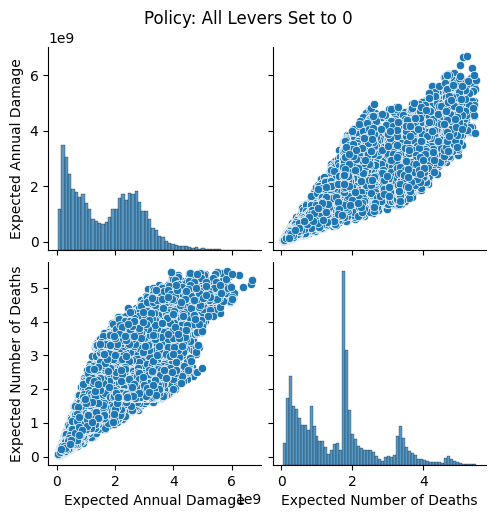

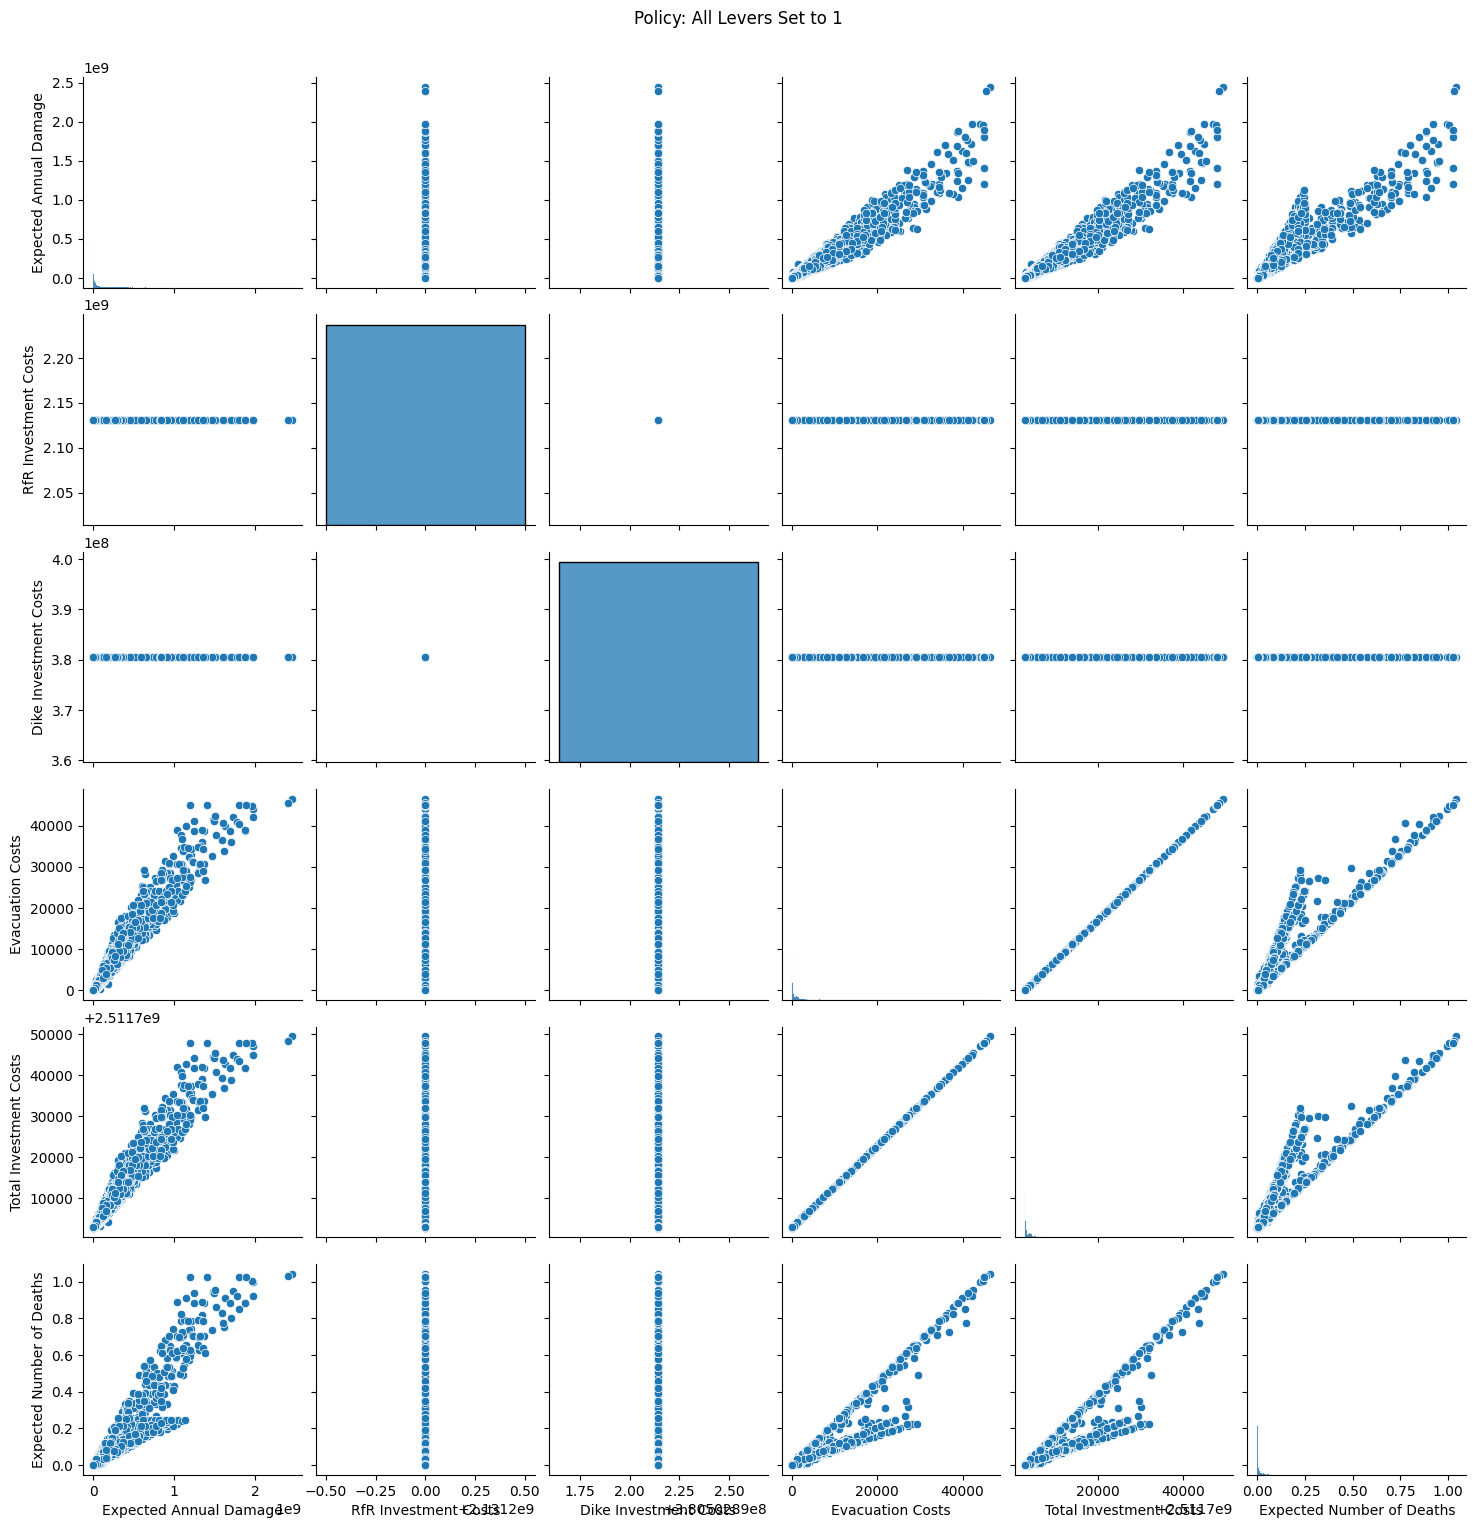

In [11]:
# Convert experiments and outcomes to DataFrames
experiments_zero_df = pd.DataFrame(experiments)
outcomes_zero_df = pd.DataFrame(outcomes)

# also do this for the one policy
experiments_one_df = pd.DataFrame(experiments1)
outcomes_one_df = pd.DataFrame(outcomes1)

# Combine the experiments and outcomes DataFrames
results_zero_df = pd.concat([experiments_zero_df, outcomes_zero_df], axis=1)
results_one_df = pd.concat([experiments_one_df, outcomes_one_df], axis=1)

# Generate pair plots for policy where levers are set to 0
# only plot the expected annual damage and expected number of deaths because the other outcomes are not 0 for no policy
sns.pairplot(results_zero_df, vars=['Expected Annual Damage','Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 0', y=1.02)
plt.show()

# Generate pair plots for policy where levers are set to 1
sns.pairplot(results_one_df, vars=['Expected Annual Damage', 'RfR Investment Costs','Dike Investment Costs',
                                        'Evacuation Costs','Total Investment Costs', 'Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 1', y=1.02)
plt.show()

## Interpretation Pairplots

### First Plot: Policy: All Levers Set to 0
- **Top Left (Histogram of Expected Annual Damage)**:
  - The histogram shows the distribution of expected annual damage. It appears to be right-skewed with a significant number of instances having low damage, but a few instances have very high damage.
- **Top Right (Scatter Plot of Expected Annual Damage vs. Expected Number of Deaths)**:
  - There is a positive correlation between expected annual damage and expected number of deaths, indicating that as damage increases, the number of deaths also tends to increase.
- **Bottom Left (Scatter Plot of Expected Annual Damage vs. Expected Number of Deaths)**:
  - This plot reiterates the positive correlation between damage and deaths with more visible data points.
- **Bottom Right (Histogram of Expected Number of Deaths)**:
  - The histogram shows the distribution of expected number of deaths. It is also right-skewed with a high frequency of low death counts and a long tail towards higher death counts.

### Second Plot: Policy: All Levers Set to 1
- This plot is a pair plot matrix showing relationships between various metrics (Expected Annual Damage, Rfr Investment Costs, Dike Investment Costs, Evacuation Costs, Total Investment Costs, and Expected Number of Deaths). Each cell in the matrix represents a scatter plot or histogram of the respective pair of variables.

- **Diagonal (Histograms)**:
  - Each diagonal cell contains a histogram showing the distribution of each variable.
  - Expected Annual Damage and Expected Number of Deaths are right-skewed.
  - Investment Costs (Rfr, Dike, Evacuation) have specific peaks indicating certain fixed values or narrow ranges of costs.

- **Off-Diagonal (Scatter Plots)**:
  - **Expected Annual Damage vs. Expected Number of Deaths**:
    - Positive correlation as observed in the first plot.
  - **Expected Annual Damage vs. Costs**:
    - Higher damages correlate with higher evacuation and total investment costs.
  - **Expected Number of Deaths vs. Costs**:
    - Higher number of deaths also correlate with higher evacuation and total investment costs.
  - **Rfr Investment Costs vs. Dike Investment Costs**:
    - These variables show very little variance, suggesting that for this policy, these costs are fixed.
  - **Costs vs. Costs**:
    - Strong correlations between different types of costs, especially evacuation costs and total investment costs, indicating these costs increase together.

### Summary:
- **Policy: All Levers Set to 0**: 
  - There is a high variation in expected annual damage and number of deaths, with positive correlation between these two metrics.
  - The costs are not represented in this plot.

- **Policy: All Levers Set to 1**:
  - Expected damages and deaths are higher, but the costs are also significantly higher, especially for evacuation and total investments.
  - The investment costs for Rfr and Dike seem to be fixed or show minimal variation.

These plots suggest that setting all levers to 0 leads to a broad distribution of possible damages and deaths, while setting all levers to 1 results in higher costs but potentially lower and more predictable damage and death outcomes. This indicates a trade-off between cost and risk when choosing a policy.